# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* [Extract layout features and visual tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* Model architecture
    * [Visual encoder, generative and discriminative heads](Model-Backbone.ipynb)
    * [Unsupervised and semi-supervise pretraining](Model-Pretraining.ipynb)
    * Supervised multi-task training
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


### Multi-task training with feedback data
This model update targets only text-reading capability.

In [1]:
import json
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from collections import Counter

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, AdamW
from torchsummary import summary
from torchmetrics import ConfusionMatrix

In [2]:
from scripts.training import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


<a name="data"></a>

## Dataset

In [4]:
samples = set([str(x)[len('data/feedback/'):-len('.csv.gz')] for x in Path('./data/feedback').glob('*.csv.gz')])
trainset = list(set(trainset).intersection(samples))
testset = list(set(testset).intersection(samples))
len(trainset), len(testset)

(189, 25)

In [5]:
SOURCE = 'feedback'

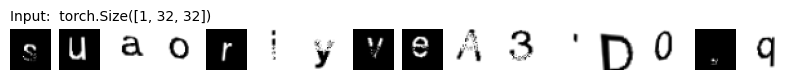

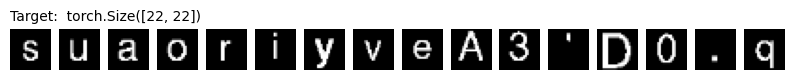

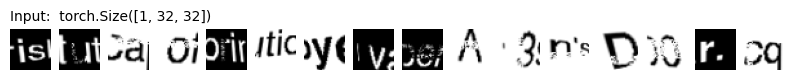

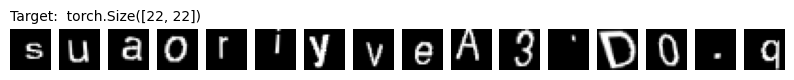

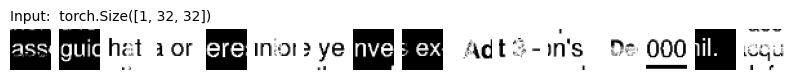

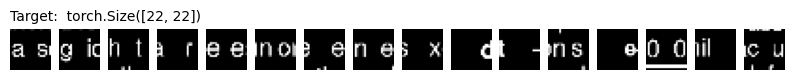

tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 3, 0, 1, 0, 2, 0])


In [6]:
source = np.random.choice(testset)

# pick the batch for evaluation
for demo_batch in DataLoader(MultitaskDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    X, Y, L = demo_batch
    for i in range(len(X)):
        show_inputs(X[i])
        show_targets(Y[i])
    break
print(L[-3])

In [7]:
semantic_labels = pd.read_csv('./data/context-weight.csv')['name'].to_list()

sample_size = 1000
# estimate semantic-class weight in this data
count = []
for source in np.random.choice(trainset, min(len(trainset), sample_size), replace=False):
    for _,_,_, S in DataLoader(ContextDataset(source, INDEX, path=SOURCE), batch_size=16):
        count += list(S.numpy())

count = pd.DataFrame(Counter(count).most_common(), columns=('class','weight')).set_index('class')
semantic_weight = count.min().iloc[0]/count
semantic_weight = semantic_weight.sort_index()
semantic_weight.index = semantic_labels
semantic_weight = semantic_weight.loc[:,'weight'].round(4)
semantic_weight

mid       0.0396
head      0.0503
tail      0.0959
single    0.2364
empty     1.0000
Name: weight, dtype: float64

In [8]:
semantic_dim = len(semantic_weight)
semantic_weight = torch.Tensor(semantic_weight.to_list()).to(DEVICE)

In [9]:
label_weight = pd.read_csv('./data/training-labels.csv')

# estimate label weight in this data
count = []
for source in np.random.choice(trainset, min(len(trainset), sample_size), replace=False):
    D = MultitaskDataset(source, INDEX, path=SOURCE)
    count += list(D.index)

count = pd.DataFrame(Counter(count).most_common(), columns=('label','count'))
label_weight = label_weight.merge(count, on='label', how='left').fillna(1).set_index('label')
label_weight['count'] = label_weight['count_x'] + label_weight['count_y']
label_weight['weight'] = (2./label_weight['count']).round(4).values
# new entries will be appended to the tail if passed stat-threshold
label_weight = label_weight.loc[(label_weight.index.str.len()==1)&(label_weight['count'] > 1)]
label_weight = label_weight.loc[INDEX[1:len(label_weight)],'weight']
print(''.join(label_weight.index.to_list()))
print(''.join(INDEX[1:]))

aeongsitfmpudlcrPbv(h2C1.)xSI-,DyFRA0EB34N5Tq6M7L98wUzOGjk'H/YéàV•:☐$J%èQêWç?ôZù»+K;▶X◀É"*ûâÀ°&▲«[îÎ]œ=✓#Ô±½@È¼§Êº▼ó>≤ñ!áäìöÂ_¢÷Œ¾ü{ú}©ëåÇ
aeongsitfmpudlcrPbv(h2C1.)xSI-,DyFRA0EB34N5Tq6M7L98wUzOGjk'H/YéàV•:☐$J%èQêWç?ôZù»+K;▶X◀É"*ûâÀ°&▲«[îÎ]œ=✓#Ô±½@È¼§Êº▼ó>≤ñ!áäìöÂ_¢÷Œ¾ü{ú}©ëåÇí


In [10]:
num_classes = len(INDEX)
# prepend `space`
label_weight = [round(1./len(trainset + testset), 4)] + label_weight.to_list()
label_weight = torch.Tensor(label_weight + [1e-6] * (num_classes - len(label_weight) - 1)).to(DEVICE)

<a name="exp"></a>

## Model

In [11]:
latent_dim = 64
num_classes = len(INDEX)

encoder = get_encoder()
# use pretrained
encoder.load_state_dict(torch.load('./models/backbone-encoder.pt'))
# freeze it
for param in encoder.parameters():
    param.requires_grad = False

keys = MultiVAE(encoder, latent_dim, num_classes).keys
semantic = ContextClassifier(keys, latent_dim, semantic_dim)
model = MultiVAE(encoder, latent_dim, num_classes, semantic=semantic, align=True, neighbors=True).to(DEVICE)

In [12]:
semantic = ContextClassifier(keys, latent_dim, semantic_dim)
model = MultiVAE(encoder, latent_dim, num_classes, semantic=semantic, align=True, neighbors=True).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])
semantic torch.Size([16, 5])
align torch.Size([16, 1, 22, 22])
left torch.Size([16, 156])
right torch.Size([16, 156])


## Training

In [13]:
PATH = f'VAE-multi-{latent_dim}-{num_classes}-{semantic_dim}-online'
model.load_state_dict(torch.load(f'./models/{PATH}.pt'))

<All keys matched successfully>

In [14]:
batch_size = 16
learning_rate = 5e-6
epochs = 5
start = 1

label_weight = torch.Tensor(WEIGHT).to(DEVICE)
label_align = nn.CrossEntropyLoss(weight=label_weight)

semantic_align = nn.CrossEntropyLoss(weight=torch.Tensor(semantic_weight).to(DEVICE))

config = {'concept': {'Reconstruction':8., 'KLD':-2., 'Contrast':0., 'Align':5.},
          'target':  {'Reconstruction':8., 'KLD':-3., 'Contrast':1., 'Align':5.},
          'context': {'Reconstruction':8., 'KLD':-4., 'Contrast':2., 'Align':5.}}

consensus = {'semantic':5., 'align':8., 'neighbors':3.}

criterion = MultitaskLoss(model.keys, config, label_align, semantic_align, consensus).to(DEVICE)
params = [p for p in model.parameters()] + [p for p in criterion.parameters()]
optimizer = SGD(params, lr=learning_rate, momentum=0.9)

history = {'train':[],'test':[]}
for epoch in range(start, epochs + 1):
    for i, source in enumerate(np.random.permutation(trainset), 1):
        train_history = train(model, MultitaskDataset(source, INDEX, path=SOURCE),
                              criterion, optimizer, batch_size=batch_size)
        test_history = validate(model, MultitaskDataset(np.random.choice(testset), INDEX, path=SOURCE),
                                criterion, batch_size=batch_size)
        # track epoch avg loss
        history['train'].append(pd.DataFrame.from_dict(train_history).mean().to_dict())
        history['test'].append(pd.DataFrame.from_dict(test_history).mean().to_dict())
        print(f"Epoch {epoch}: {i/len(trainset):<7.2%}  "
              f"train: {history['train'][-1]['Loss']:<5.0f}  "
              f"test: {history['test'][-1]['Loss']:<5.0f}  "
              f"context: {history['test'][-1]['context-Align']:<5.2f}  "
              f"left: {history['test'][-1]['left']:<5.2f}  "
              f"right: {history['test'][-1]['right']:<5.2f}  "
              f"semantic: {history['test'][-1]['semantic']:<.2f}  "
              , end='\r')

    torch.save(model.state_dict(), f'./models/{PATH}.pt')
    with open(f'./output/{PATH}-{epoch}.json','w') as output:
        json.dump(history, output)
        history = {'train':[],'test':[]}

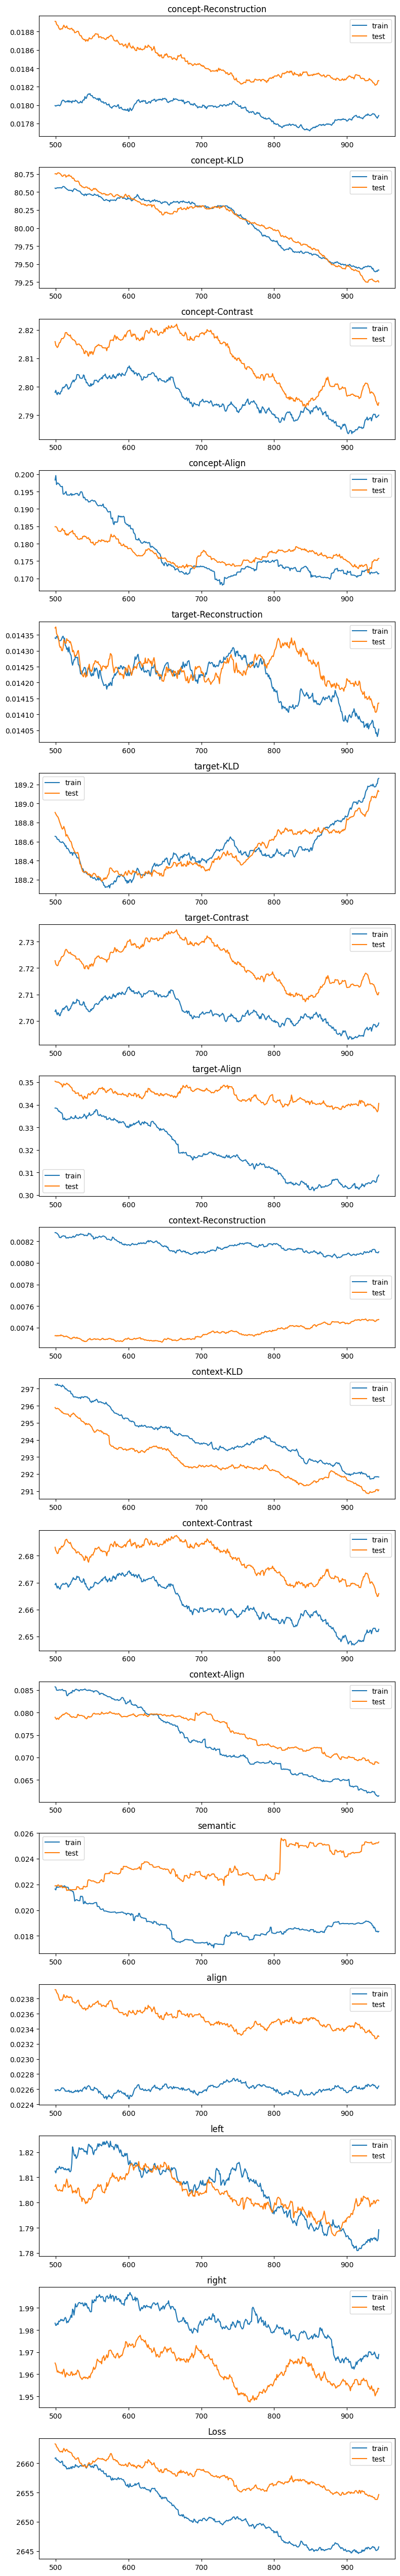

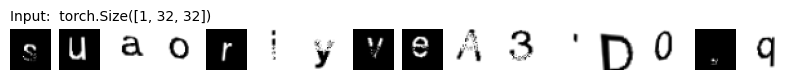

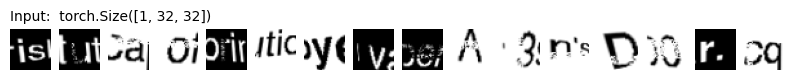

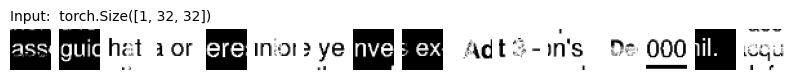


------- concept output -------------------------------------------


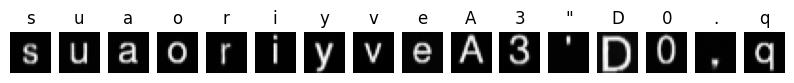


------- target  output -------------------------------------------


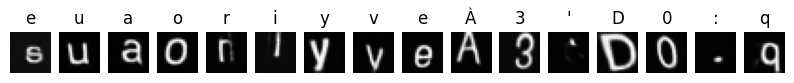


------- context output -------------------------------------------


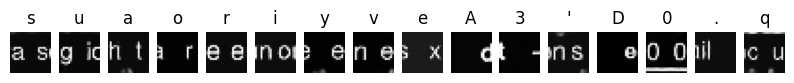

In [15]:
plot_results(PATH, window=100 * epoch, save=True)

X, Y, L = demo_batch
show_inputs(X[0])
show_inputs(X[1])
show_inputs(X[2])
with torch.no_grad():
    model.eval()
    n = len(X[0])
    output = model([x.to(DEVICE) for x in X])
    for j, m in enumerate(model.tags):
        print(f'\n------- {m:<7} output -------------------------------------------')
        a, b = model.keys.index(f'{m}-rec'), model.keys.index(f'{m}-label')
        fig, ax = plt.subplots(1, n, figsize=(10, 10))
        R = output[a].cpu().squeeze().numpy()
        P = np.argmax(torch.softmax(output[b], dim=1).cpu().squeeze().numpy(), axis=1)
        for i in range(n):
            ax[i].imshow(R[i,:], 'gray')
            ax[i].set_title(INDEX[P[i]])
            ax[i].axis('off')
        plt.show()

## Evaluation
This time we run evaluation with both feedback dataset and the original training dataset.

In [16]:
label_confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(DEVICE)
semantic_confmat = ConfusionMatrix(task='multiclass', num_classes=semantic_dim).to(DEVICE)

label_matrix = [np.zeros((num_classes, num_classes)) for _ in range(len(model.tags) + 2)]
semantic_matrix = np.zeros((semantic_dim, semantic_dim))

model.eval()
with torch.no_grad():
    for source in testset:
        loader = DataLoader(MultitaskDataset(source, INDEX, path='feedback'), batch_size=16)
        for batch in loader:
            X, Y, L = batch
            n = len(X[0])
            output = model([x.to(DEVICE) for x in X])
            for i, tag in enumerate(model.tags):
                P = torch.argmax(torch.softmax(output[model.keys.index(f'{tag}-label')], dim=1), dim=1)
                label_matrix[i] += label_confmat(P, L[0].to(DEVICE)).cpu().numpy()
            for i, side in enumerate(['left','right'], len(model.tags)):
                P = torch.argmax(torch.softmax(output[model.keys.index(side)], dim=1), dim=1)
                label_matrix[i] += label_confmat(P, L[i - 1].to(DEVICE)).cpu().numpy()                    
            P = torch.argmax(torch.softmax(output[model.keys.index('semantic')], dim=1), dim=1)
            semantic_matrix += semantic_confmat(P, L[1].to(DEVICE)).cpu().numpy()

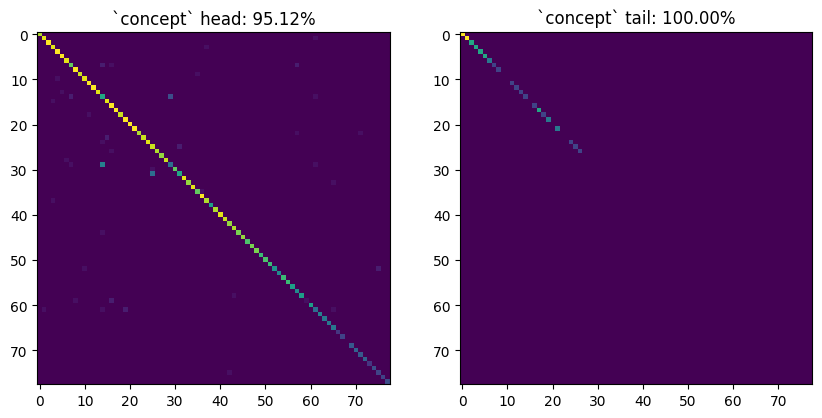

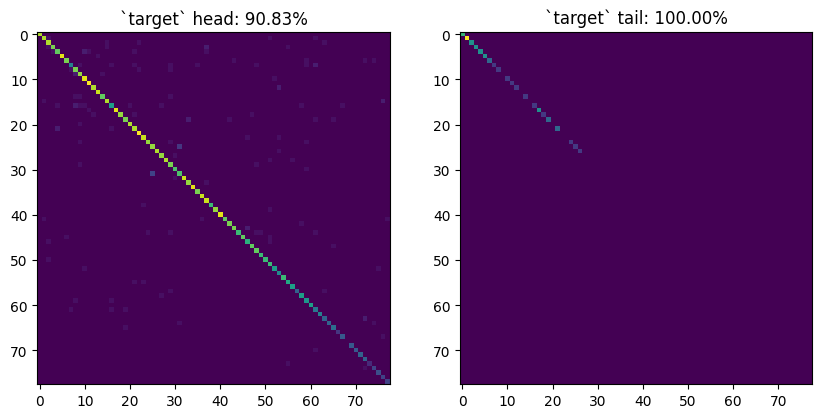

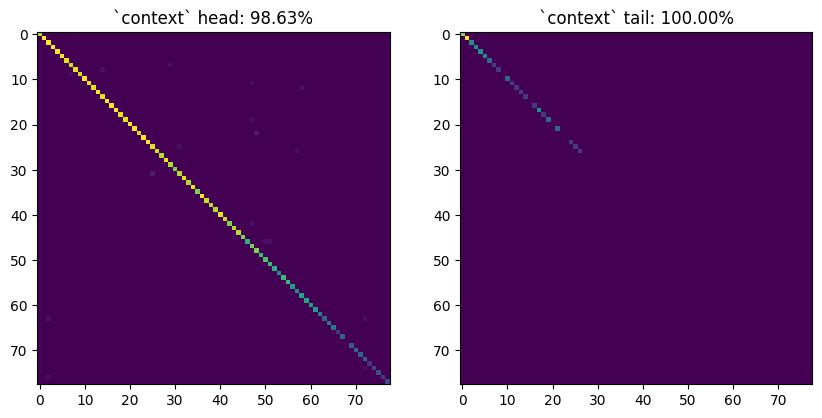

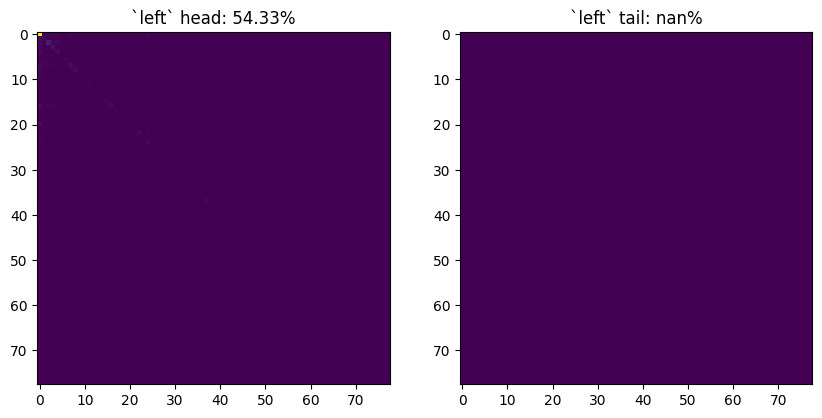

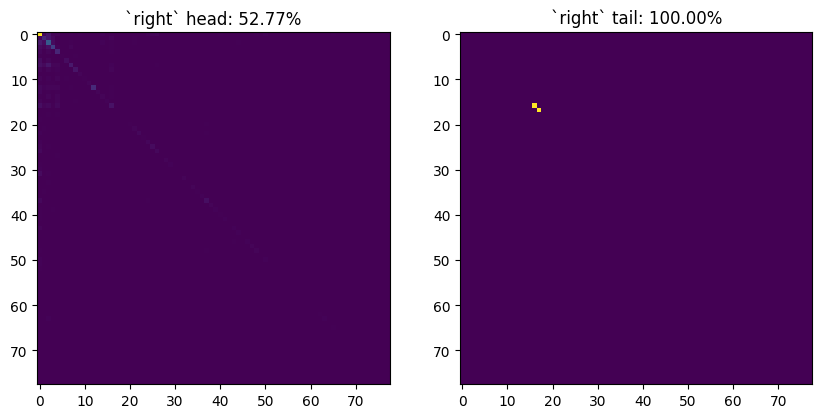

In [17]:
for i, tag in enumerate(model.tags + ['left','right']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    a, b = num_classes//2, num_classes
    ax[0].imshow(label_matrix[i][:a,:a])
    ax[0].set_title(f'`{tag}` head: {label_matrix[i][:a,:a].trace()/label_matrix[i][:a,:a].sum():.2%}')
    ax[1].imshow(label_matrix[i][a:b,a:b])
    ax[1].set_title(f'`{tag}` tail: {label_matrix[i][a:b,a:b].trace()/label_matrix[i][a:b,a:b].sum():.2%}')
    plt.savefig(f'./output/{PATH}-{tag}.png')
    plt.show()

In [18]:
# concept classification tail (less certain)
goals, misses = get_rates(label_matrix[0])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
W,W,5,6,83
Z,Z,5,6,83
w,w,13,16,81
i,i,19,24,79
/,/,9,14,64
E,E,14,22,63
l,l,15,24,62
",",",",15,24,62
:,:,5,8,62


In [19]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
É,E,2,2,100
',"""",11,15,73
I,l,11,22,50
",",.,9,24,37
:,;,3,8,37
E,É,8,22,36
l,I,6,24,25
/,v,2,14,14
',r,2,15,13


In [20]:
# target classification tail (less certain)
goals, misses = get_rates(label_matrix[1])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
l,l,19,24,79
T,T,17,22,77
E,E,17,22,77
n,n,19,25,76
Q,Q,3,4,75
",",",",18,24,75
/,/,10,14,71
j,j,8,12,66
r,r,14,25,56


In [21]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
",",.,5,24,20
é,è,2,10,20
.,",",4,25,16
E,É,3,22,13
i,î,3,24,12
5,6,2,22,9
i,/,2,24,8
f,t,2,24,8
o,0,2,25,8


In [22]:
# context classification tail (less certain)
goals, misses = get_rates(label_matrix[2])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
f,f,23,24,95
q,q,20,21,95
N,N,20,21,95
2,2,23,25,92
",",",",22,24,91
Y,Y,10,11,90
6,6,16,18,88
ê,ê,5,6,83
ç,ç,4,5,80


In [23]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
",",.,2,24,8
2,7,2,25,8


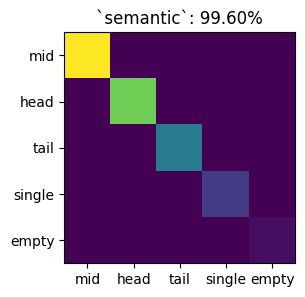

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(semantic_matrix)
ax.set_xticks(range(semantic_dim))
ax.set_yticks(range(semantic_dim))
ax.set_xticklabels(semantic_labels)
ax.set_yticklabels(semantic_labels)
ax.set_title(f'`semantic`: {semantic_matrix.trace()/semantic_matrix.sum():.2%}')
plt.savefig(f'./output/{PATH}-semantic.png')
plt.show()

With the original training dataset:

In [25]:
label_confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(DEVICE)
semantic_confmat = ConfusionMatrix(task='multiclass', num_classes=semantic_dim).to(DEVICE)

label_matrix = [np.zeros((num_classes, num_classes)) for _ in range(len(model.tags) + 2)]
semantic_matrix = np.zeros((semantic_dim, semantic_dim))

model.eval()
with torch.no_grad():
    for source in testset:
        loader = DataLoader(MultitaskDataset(source, INDEX, path='training'), batch_size=16)
        for batch in loader:
            X, Y, L = batch
            n = len(X[0])
            output = model([x.to(DEVICE) for x in X])
            for i, tag in enumerate(model.tags):
                P = torch.argmax(torch.softmax(output[model.keys.index(f'{tag}-label')], dim=1), dim=1)
                label_matrix[i] += label_confmat(P, L[0].to(DEVICE)).cpu().numpy()
            for i, side in enumerate(['left','right'], len(model.tags)):
                P = torch.argmax(torch.softmax(output[model.keys.index(side)], dim=1), dim=1)
                label_matrix[i] += label_confmat(P, L[i - 1].to(DEVICE)).cpu().numpy()                    
            P = torch.argmax(torch.softmax(output[model.keys.index('semantic')], dim=1), dim=1)
            semantic_matrix += semantic_confmat(P, L[1].to(DEVICE)).cpu().numpy()

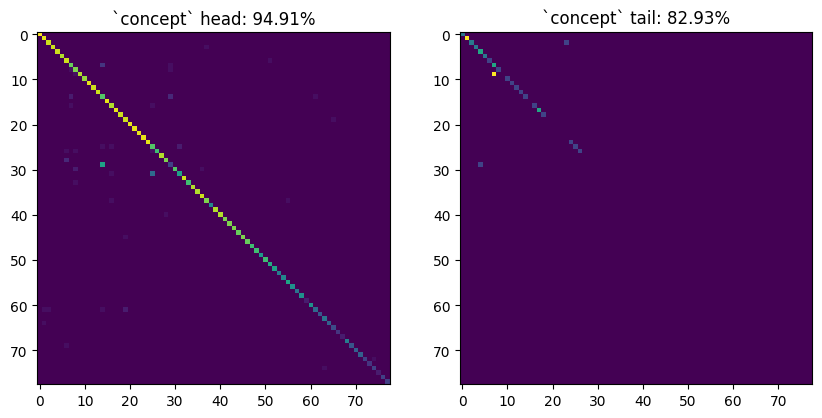

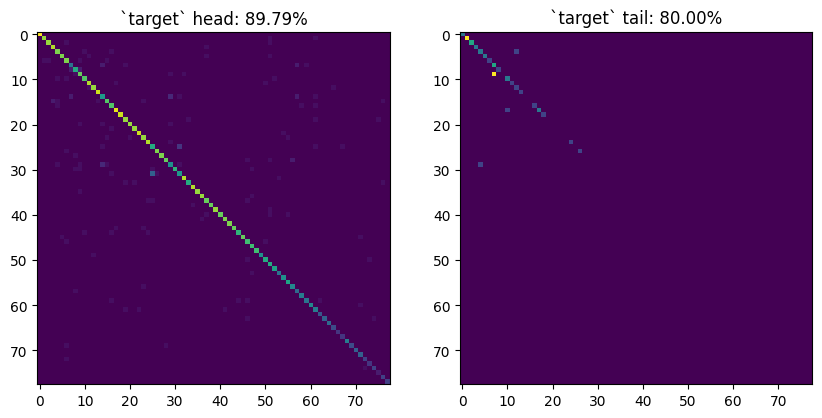

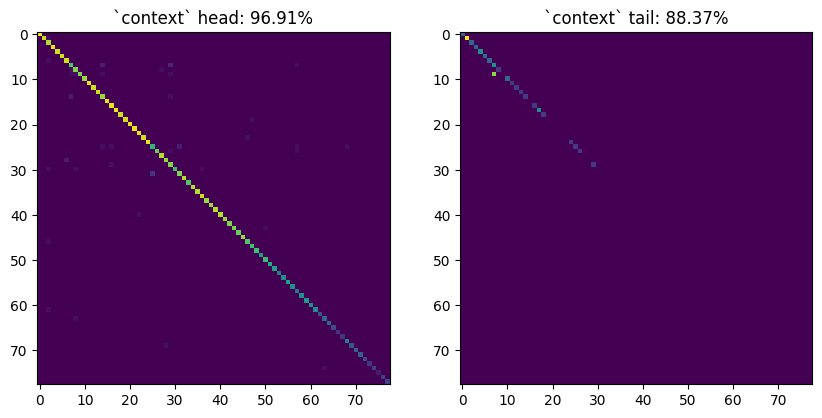

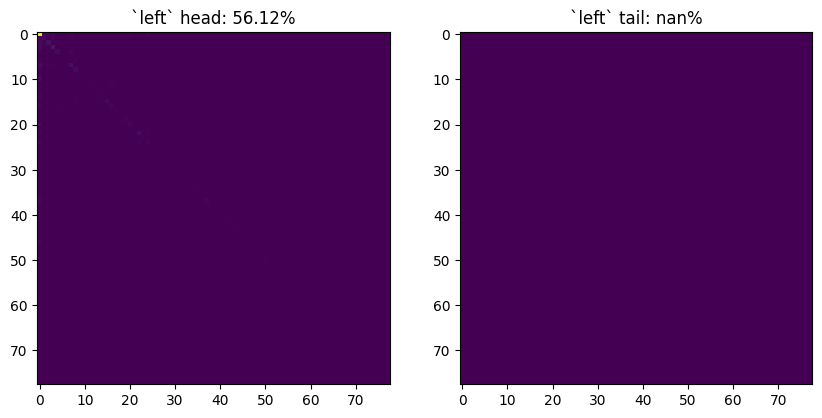

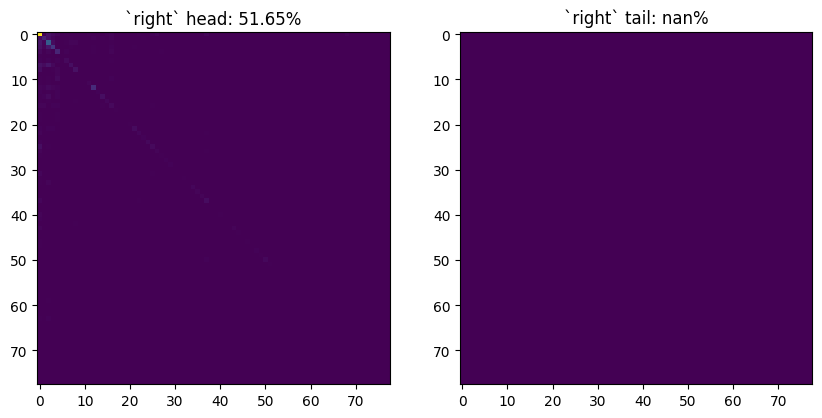

In [26]:
for i, tag in enumerate(model.tags + ['left','right']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    a, b = num_classes//2, num_classes
    ax[0].imshow(label_matrix[i][:a,:a])
    ax[0].set_title(f'`{tag}` head: {label_matrix[i][:a,:a].trace()/label_matrix[i][:a,:a].sum():.2%}')
    ax[1].imshow(label_matrix[i][a:b,a:b])
    ax[1].set_title(f'`{tag}` tail: {label_matrix[i][a:b,a:b].trace()/label_matrix[i][a:b,a:b].sum():.2%}')
    plt.savefig(f'./output/{PATH}-{tag}.png')
    plt.show()

In [27]:
# concept classification tail (less certain)
goals, misses = get_rates(label_matrix[0])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
),),18,22,81
i,i,20,25,80
l,l,19,25,76
ù,ù,2,3,66
/,/,9,14,64
",",",",15,25,60
E,E,12,22,54
:,:,2,5,40
I,I,5,22,22


In [28]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
◀,▶,5,5,100
',"""",12,14,85
I,l,15,22,68
:,;,3,5,60
E,É,10,22,45
",",.,9,25,36
i,l,4,25,16
/,v,2,14,14
S,s,3,24,12


In [29]:
# target classification tail (less certain)
goals, misses = get_rates(label_matrix[1])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
$,$,6,8,75
',',10,14,71
.,.,16,23,69
t,t,16,23,69
+,+,2,3,66
&,&,2,3,66
I,I,13,22,59
l,l,14,25,56
",",",",14,25,56


In [30]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
◀,▶,5,5,100
",",.,8,25,32
i,î,6,25,24
.,",",4,23,17
k,K,2,13,15
I,l,3,22,13
t,î,3,23,13
l,I,3,25,12
t,i,2,23,8


In [31]:
# context classification tail (less certain)
goals, misses = get_rates(label_matrix[2])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
l,l,22,25,88
$,$,7,8,87
f,f,21,25,84
",",",",21,25,84
ê,ê,5,6,83
-,-,18,22,81
:,:,4,5,80
i,i,19,25,76
.,.,17,23,73


In [32]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
◀,▶,5,5,100
",",.,4,25,16
i,I,3,25,12
.,",",2,23,8
S,s,2,24,8
i,l,2,25,8
l,i,2,25,8


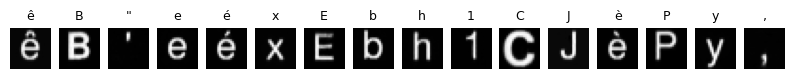

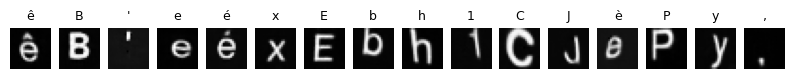

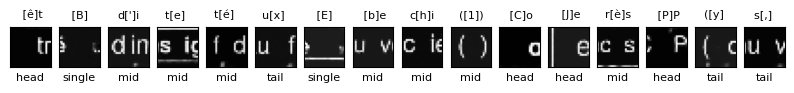

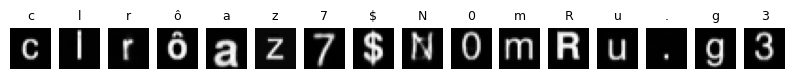

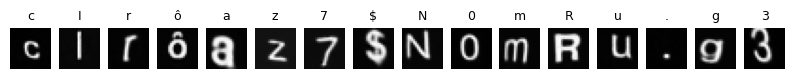

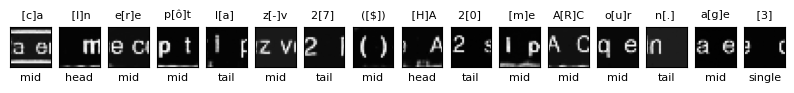

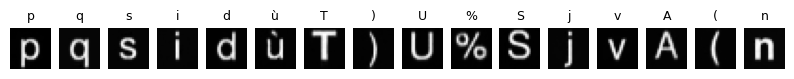

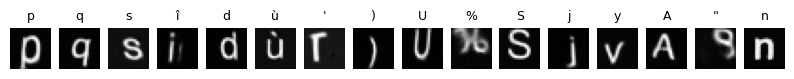

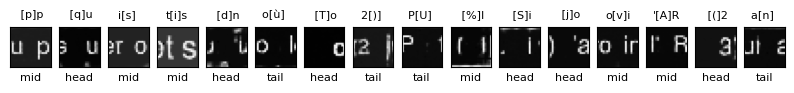

In [33]:
model.eval()
with torch.no_grad():
    source = np.random.choice(testset)
    #loader = DataLoader(MultitaskDataset(source, INDEX, path='training', amp=16), batch_size=16) # batch of each
    loader = DataLoader(MultitaskDataset(source, INDEX, path='training'), batch_size=16)
    for X, Y, _ in loader:
        n = len(X[0])
        if n < 16: break
        output = model([x.to(DEVICE) for x in X])
        S = np.argmax(torch.softmax(output[model.keys.index('semantic')], dim=1).cpu().squeeze().numpy(), axis=1)
        left = np.argmax(torch.softmax(output[model.keys.index('left')], dim=1).cpu().squeeze().numpy(), axis=1)
        right = np.argmax(torch.softmax(output[model.keys.index('right')], dim=1).cpu().squeeze().numpy(), axis=1)
        for j, m in enumerate(model.tags):
            a, b = model.keys.index(f'{m}-rec'), model.keys.index(f'{m}-label')
            fig, ax = plt.subplots(1, 16, figsize=(10, 10))
            R = output[a].cpu().squeeze().numpy()
            P = np.argmax(torch.softmax(output[b], dim=1).cpu().squeeze().numpy(), axis=1)
            for i in range(16):
                ax[i].imshow(R[i,:], 'gray')
                if m == 'context':
                    ax[i].set_title(f'{INDEX[left[i]]}[{INDEX[P[i]]}]{INDEX[right[i]]}', fontsize=8)
                    ax[i].set_xlabel(semantic_labels[S[i]], fontsize=8)
                    ax[i].set_xticks([])
                    ax[i].set_yticks([])
                else:
                    ax[i].set_title(INDEX[P[i]], fontsize=9)
                    ax[i].axis('off')
            plt.savefig(f'./output/{PATH}-eval.png')
            plt.show()
        print(' ')

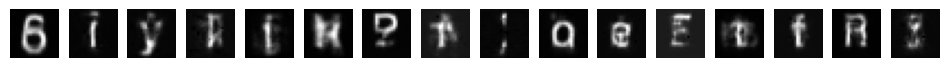

In [34]:
# generate some `concept` samples
model.eval()
with torch.no_grad():
    samples = model.concept.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

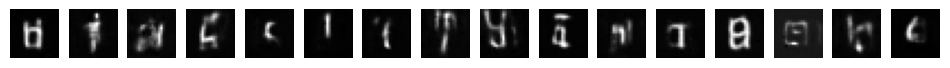

In [35]:
# generate some `focus` samples
model.eval()
with torch.no_grad():
    samples = model.target.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

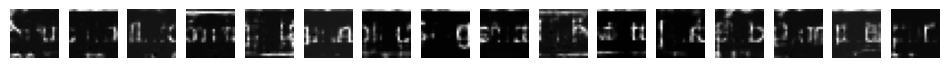

In [36]:
# generate some `context` samples
model.eval()
with torch.no_grad():
    samples = model.context.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()